## ParFlow-CLM Water Balance Exercise
This notebook runs a ParFlow-CLM simulation and loads data to compare the fluxes calculated in CLM to the vector passed to ParFlow.  It covers some basics of model coupling and LSM processes.

### Goal
The goal of this exercise is to understand the setup and simulation results of a fully coupled ParFlow-CLM run. Processes included in this exercise are water redistriubtion in the variably saturated subsurface with overland flow at the surface and coupling with land surface processes related to evaporation, transpiration (root water uptake by plants) and infiltration (precipitation minus evaporation). A water balance illustrates the results.  

### Run ParFlow-CLM for 24 hours
The first cell of this notebook runs a single-column PF-CLM for a day, saving the output for analysis below.

### ParFlow-CLM water balance
The next cell in this notebook conducts a water balance with CLM output variables and the `EvapTrans` vector output by ParFlow.  This vector is an output of what CLM passes to ParFlow every timestep and can be used for diagnostics.  This vector can be used (as we did in earlier notebooks) to conduct a water balance of ParFlow but in this case we are just comparing the CLM output variables to the `EvapTrans` vector.   

/home/ms6985/ParFlow-project/pfclm_sc
/home/ms6985/ParFlow-project/pfclm_sc/output_water_balance
/home/ms6985/ParFlow-project/pfclm_sc/forcing
  - qflx_tran_vegm


/home/ms6985/myenv/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)



Table of water balance values:
 balance    balance2   evap_trans residual   residual2
 2.625e-01  2.625e-01  2.625e-01  5.551e-17  5.551e-17
 2.041e-01  2.041e-01  2.041e-01  0.000e+00  0.000e+00
 1.547e-01  1.547e-01  1.547e-01  0.000e+00  0.000e+00
 2.385e-01  2.385e-01  2.385e-01 -5.551e-17 -5.551e-17
 3.525e-01  3.525e-01  3.525e-01 -5.551e-17  0.000e+00
 4.637e-01  4.637e-01  4.637e-01  0.000e+00  0.000e+00
 5.239e-01  5.239e-01  5.239e-01  1.110e-16  1.110e-16
 5.828e-01  5.828e-01  5.828e-01  0.000e+00  0.000e+00
 6.418e-01  6.418e-01  6.418e-01  0.000e+00  0.000e+00
 5.381e-01  5.381e-01  5.381e-01  1.110e-16  1.110e-16
 4.345e-01  4.345e-01  4.345e-01  0.000e+00  0.000e+00
 3.316e-01  3.316e-01  3.316e-01  5.551e-17  0.000e+00
 1.048e-01  1.048e-01  1.048e-01  0.000e+00  0.000e+00
-9.273e-02 -9.273e-02 -9.273e-02  0.000e+00  0.000e+00
-2.870e-01 -2.870e-01 -2.870e-01 -5.551e-17 -5.551e-17
-1.772e+00 -1.772e+00 -1.772e+00 -2.220e-16 -2.220e-16
-4.699e+00 -4.699e+00 -4.699e+00 

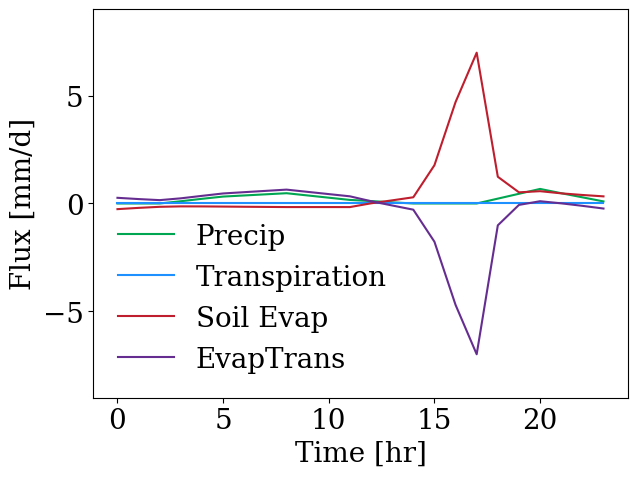

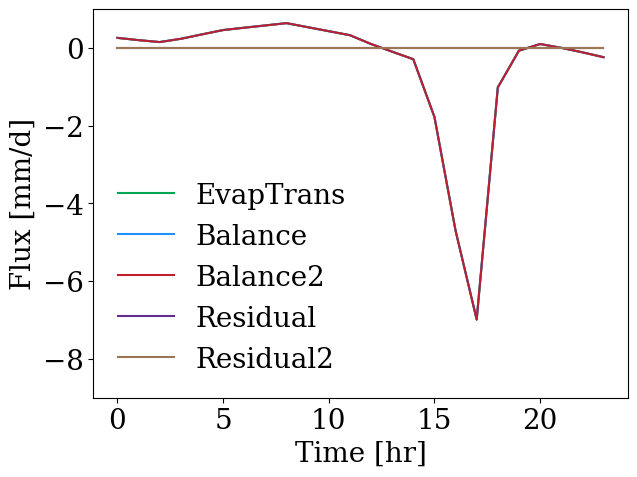

In [22]:
## load PFCLM output and conduct a detailed water balance

import parflow as pf
import matplotlib.pyplot as plt
import numpy as np
from set_demo_defaults import *
import os
#import netCDF4 as nc
import xarray as xr
import time as timer
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from glob import glob
import pandas as pd
import parflow as pf
from pathlib import Path

from parflow import Run
import parflow.tools.hydrology as hydro

path = ''
current_dir = os.getcwd()
print(current_dir)
relative_path_to_runfolder = 'output_water_balance'
path = current_dir+'/'+relative_path_to_runfolder
print(path)

path_forcing = current_dir+'/forcing'
print(path_forcing)


# load in the run information from the PFIDB file

alpha_vG = 2  #Set alpha for vanGenuchten model


run_name = 'PFCLM_SC'
run = Run.from_definition(f'{path}/{run_name}.pfidb')
data = run.data_accessor
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz


# intialize data and time arrays
data    = np.zeros([8,8760])
time    = np.zeros([8760])

#CLM data array format 
# reading the CLM file PFCLM_SC.out.clm_output.<file number>.C.pfb
# variables are by layer:
# 0 eflx_lh_tot:  total latent heat flux (Wm-2)  
# 1 eflx_lwrad_out: total upward LW radiation (Wm-2)  
# 2 eflx_sh_tot: total sensible heat flux (Wm-2)  
# 3 eflx_soil_grnd: ground heat flux (Wm-2)    
# 4 qflx_evap_tot: net veg. evaporation and transpiration and soil evaporation (mms-1)  
# 5 qflx_evap_grnd: ground evaporation (mms-1)   
# 6 qflx_evap_soi: soil evaporation (mms-1)   
# 7 qflx_evap_veg: vegetation evaporation (canopy) and transpiration (mms-1)   
# 8 qflx_tran_veg: transpiration (mms-1)  
# 9 qflx_infl: infiltration flux (mms-1)   
# 10 swe_out: SWE (mm)   
# 11 t_grnd: ground temperature (K)  
# 12 irrigation flux
# 13 - 24 Soil temperature by layer (K)


#  assemble files to be loaded as an entire sequence
# then map specific variables to the data array which holds things for analysis
# and plotting

files = glob(path+"/PFCLM_SC.out.clm_output.*.C.pfb")
#print(files[0,10])
CLM_data = pf.read_pfb_sequence(files)

## create data frame for CLM output ET vars
clm_output = pd.DataFrame({'T [mm/s]':CLM_data[:,8,0,0],'Ebs [mm/s]':CLM_data[:,6,0,0],'Qflux infil [mm/s]':CLM_data[:,9,0,0],'Qflux irrig [mm/s]':CLM_data[:,12,0,0],'qflx_evap_grnd [mm/s]':CLM_data[:,5,0,0] })
## the variables we use here are chosen to represent the fluxes passed to ParFlow, detailed below

## load in the evaptrans output, this is constructed in the coupling between PF and CLM as follows:
## see [pf_couple.F90](https://github.com/parflow/parflow/blob/master/pfsimulator/clm/pf_couple.F90)
## looping over the columns, t, for a depth, k, the uppermost soil layer is assigned
## the infiltration flux (qflx_infl) + irrigation water applied - transpiration (qflx_tran_veg):
#LINE 40: clm(t)%pf_flux(k)=(-clm(t)%qflx_tran_veg*clm(t)%rootfr(k)) + clm(t)%qflx_infl + clm(t)%qflx_qirr_inst(k)
## layers below this are assigned the transpiration X the root fraction.  
## Note that if there are errors in the root fraction due to incomplete resolution of the root zone (not deep enough)
## this might cause errors.
#LINE 43: clm(t)%pf_flux(k)=(-clm(t)%qflx_tran_veg*clm(t)%rootfr(k)) + clm(t)%qflx_qirr_inst(k)
## Note that the fluxes are in [mm/s] units and are converted to [m/h] 3600 [s/h] and 
## 1000 [mm/m] to be in PF units and then divided by the depth of each soil layer to be in [1/h] units:
#evap_trans(l) = clm(t)%pf_flux(k) * 3.6d0 / clm(t)%dz(k)
## note that the infiltration flux is assembled to be I-E (E is *just* bare soil evaporation) and note that I is the 
## "water that hits the ground" in CLM, so this is canopy throughfall + snowmelt and will not always equal the forcing Precip
## the qflx_infl variable is assembled in 
## [clm_hydro_soil.F90](https://github.com/parflow/parflow/blob/master/pfsimulator/clm/clm_hydro_soil.F90)
#LINE 144: clm%qflx_infl = clm%qflx_top_soil - clm%qflx_evap_grnd
## where the qflx_top_soil is the water and snow that hit the ground:
#clm_hydro_canopy.F90:     clm%qflx_rain_grnd = clm%qflx_prec_grnd  ! liquid water onto ground (mm/s)
#clm_hydro_snow.F90:     clm%qflx_top_soil = clm%qflx_rain_grnd + clm%qflx_snomelt


## assemble the evap trans files
files = glob(path+"/PFCLM_SC.out.evaptrans.*.pfb")
pf_EvapTrans = pf.read_pfb_sequence(files)

# set up an evap_trans array to hold the summed values for the evap trans output
evap_trans = np.zeros(24)
for i in range(24):
    evap_trans[i] = np.sum(pf_EvapTrans[i,:,0,0]*dz)*1000.*24  # to go from 1/h to m/h to mm/h to mm/day


# load forcing, single column, variables are
#DSWR:  Downward Visible or Short-Wave radiation [W/m2]
#DLWR:  Downward Infa-Red or Long-Wave radiation [W/m2]
#APCP:  Precipitation rate [mm/s]
#Temp:  Air temperature [K]
#UGRD:  West-to-East or U-component of wind [m/s]
#VGRD:  South-to-North or V-component of wind [m/s]
#Press: Atmospheric Pressure [pa]
#SPFH:  Water-vapor specific humidity [kg/kg]


# load the forcing file into a Pandas dataframe
# we could load this file directly, as is shown in the commented-out line, but we can also
# use the key database and load it dynamically as shown
#file = path_forcing+"/narr_1hr.txt"
file = path_forcing+'/'+run.Solver.CLM.MetFileName

# 1D forcing files are text columns not technically CSVs but this is an easy 
# way to load
forcing_df = pd.read_csv(file,sep='\s{2,}',header=None,engine='python')
# add PF-CLM variable names and units 
forcing_df.columns = ["DSWR [W/m2]", "DLWR [W/m2]", "APCP [mm/s]", "Temp [K]", "UGRD [m/s]","VGRD [m/s]","Press [pa]","SPFH [kg/kg]"]

# calculate the water balance from CLM to PF
# we will calculate this two ways, using the forcing (balance) and the output of bare soil eval and Transpiration
# and using the qflux infil (balance2) and the transpiration.  We will compare these two approaches below
# note that our precip input and the flux outputs are all in [mm/s] units.  We convert to mm/d for more friendly units
balance = forcing_df['APCP [mm/s]'].iloc[0:24]*(3600*24)- (clm_output['T [mm/s]'].apply(pd.to_numeric)*(3600*24) + clm_output['Ebs [mm/s]'].apply(pd.to_numeric)*(3600*24))
balance2 = (clm_output['Qflux irrig [mm/s]'].apply(pd.to_numeric)*(3600*24)+ clm_output['Qflux infil [mm/s]'].apply(pd.to_numeric)*(3600*24))

# calculate two residuals, checked against the evap_trans values, corresponding to balance and balance2 above 
residual = (balance - evap_trans)
residual2 = (balance2 - evap_trans)

# we make a table of the water balances and corresponding residuals
print()
print("Table of water balance values:")
print(" balance    balance2   evap_trans residual   residual2")
for i in range (24):
    print('% 5.3e % 5.3e % 5.3e % 5.3e % 5.3e' % (balance[i], balance2[i],evap_trans[i],residual[i],residual2[i]))


# Plot the inputs to this water balance calculation
plt.plot(forcing_df['APCP [mm/s]'].iloc[0:24]*(3600*24), label='Precip', color=green)  
plt.plot(clm_output['T [mm/s]']*(3600*24), label='Transpiration', color=blue)  
plt.plot(clm_output['Ebs [mm/s]']*(3600*24), label='Soil Evap', color=red)  
plt.plot(evap_trans, label='EvapTrans', color=purple) 
plt.xlabel('Time [hr]')  
plt.ylabel('Flux [mm/d]')  ## note that we converted the fluxes to mm/d
plt.legend()
plt.ylim([-9,9])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.legend(loc='best', frameon=False)
plt.savefig(f'PFCLM_plot_alpha{alpha_vG}_water_balance_fluxes.pdf',bbox_inches='tight', dpi = 600)
plt.show()

# Plot the different forcing term calculations, Evap Trans, and the residuals
plt.plot(evap_trans, label='EvapTrans', color=green)  
plt.plot(balance, label='Balance', color=blue)  
plt.plot(balance2, label='Balance2', color=red)  
plt.plot(residual, label='Residual', color=purple)  
plt.plot(residual2, label='Residual2', color=brown)  
plt.xlabel('Time [hr]')  
plt.ylabel('Flux [mm/d]')  
plt.legend()
plt.ylim([-9,1])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.legend(loc='best', frameon=False)
plt.savefig(f'PFCLM_plot_alpha{alpha_vG}_water_balance_residuals.pdf',bbox_inches='tight', dpi = 600)
plt.show()


### Question: *Why are there differences between the approaches for calculating fluxes from CLM to PF?*
The two approaches `Balance` and `Balance2` are very similar but not exactly the same.  Is this close-enough or are we missing water somewhere?  If so, why might this be?

### Task: Discuss these questions in your small groups, determine if the water balance is *close-enough* or if water is being missed.  What might this water be?  How might you determine what differences might exist between output variables in `CLM`?

In [23]:
base = f'{path}/{run_name}'
print(base)
def plot_vert_var(base,variable, timestep=0,alpha_=2):
    """Function to plot output from a ParFlow run"""

    # Load the run from the file, this is the same as the run defined above
    run = Run.from_definition(f'{base}.pfidb')  

    data = run.data_accessor # get the data accessor, this makes it easier to access the data from the run
    nt = len(data.times)  # get the number of time steps
    nx = data.shape[2]    # get the number of cells in the x direction
    ny = data.shape[1]    # get the number of cells in the y direction
    nz = data.shape[0]    # get the number of cells in the z direction
    dx = data.dx          # get the cell size in the x direction
    dy = data.dy          # get the cell size in the y direction
    dz = data.dz          # get the cell size in the z direction, this is a 1D array of size nz

    # Print a summary of the run data
    print(f"nx = {nx}, ny = {ny}, nz = {nz}, nt = {nt}")
    print(f"dx = {dx}, dy = {dy}, dz = {dz[0]}")

    # Load the data
    if variable == "porosity":
        data = read_pfb(get_absolute_path(f"PFCLM_SC.out.{variable}.pfb")).reshape(nz, nx)
    elif variable == "mannings":
        data = read_pfb(get_absolute_path(f"PFCLM_SC.out.mannings.pfb"))[0, :, :]
    else:
        data = read_pfb(get_absolute_path(f"PFCLM_SC.out.{variable}.{str(timestep).zfill(5)}.pfb")).reshape(nz, nx)
    
    # Set negative saturation values to NaN
    if variable == "satur":
        data[data < 0.0] = np.nan
    
    # Set up x and z to match the shape of the ParFlow grid
    x = np.arange(0.0,(nx+1)*dx,dx)
    y = np.arange(0.0,(ny+1)*dy,dy)
    z = np.zeros(nz+1)
    z[1:] = np.cumsum(dz)

    print(f"x = {x}, y = {y}, z = {z}")
    print(f"Shapes of : x = {x.shape}, y = {y.shape}, z = {z.shape}")

    # Get limits for plotting
    vmin = np.nanmin(data)
    vmax = np.nanmax(data)
    print(f"vmin: {vmin}, vmax: {vmax}")
    
    # Define labels for plots
    if variable == "satur":
        label = "Saturation [-]"
        title = "Saturation"
    elif variable == "press":
        label = "Pressure Head [m]"
        title = "Pressure Head"
    elif variable == "porosity":
        label = "Porosity"
        title = "Porosity"
    elif variable == "mannings":
        label = "Mannings"
        title = "Mannings"

    # Use pcolormesh to plot the data with the x and z coordinates with lines 
    # for the grid mesh from the ParFlow run grid

    #im = ax.pcolormesh(x, y, data, vmin=vmin, vmax=vmax, cmap='plasma_r')
    fig = plt.figure(figsize=(8,8) , dpi=100)
    im = plt.plot(data,z[1:]-dz/2)#Plotting at cell centers
    plt.xlabel(f"{title}")
    plt.ylabel('z [m]')
    if variable in ["porosity", "mannings"]:
        plt.title(f"{title}")
    else:
        plt.title(f"{title} at t={timestep}")
    plt.show()
    plt.xlabel(f"{title}")
    plt.ylabel('z [m]')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.legend(loc='best', frameon=False)
    plt.savefig(f'contour_alphavG{alpha_}_s_w_vs_depth.pdf',bbox_inches='tight', dpi = 600)
    plt.show()


plot_vert_var(base, "satur", 0,alpha_vG)

/home/ms6985/ParFlow-project/pfclm_sc/output_water_balance/PFCLM_SC
  - qflx_tran_vegm
nx = 1, ny = 1, nz = 20, nt = 25
dx = 2.0, dy = 2.0, dz = 1.0


/home/ms6985/myenv/lib/python3.11/site-packages/parflow/tools/io.py:1300: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_name, delim_whitespace=True, skiprows=2, header=None)


FileNotFoundError: [Errno 2] No such file or directory: '/home/ms6985/ParFlow-project/pfclm_sc/output_water_balance/domain_example.out.satur.00000.pfb'